In [1]:
import math
import itertools
from pathlib import Path
import lzma
import json

from matplotlib import pyplot as plt
import numpy as np
import scipy
import scipy.signal as sig
import RigolWFM.wfm as rigol
from reedmuller.reedmuller import ReedMuller
%matplotlib inline

Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples


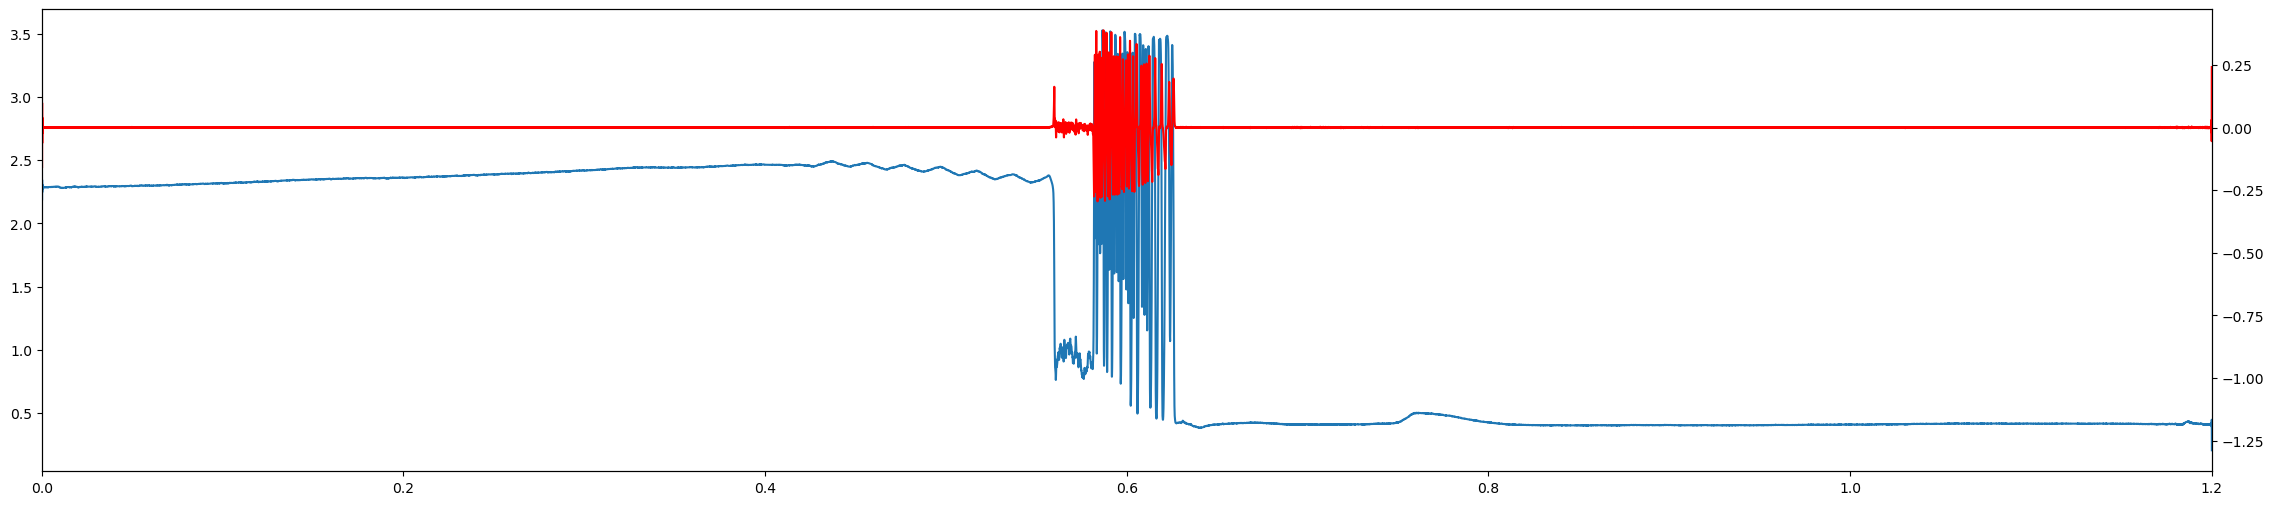

In [2]:
#wf = rigol.Wfm.from_file('barcode_test_varspeed.wfm', 'DS1054Z')
# Initial test with waveforms/manchester/manchester_rm_1234567_04.wfm
wfs = []
ref_data = []
for f in Path('waveforms/manchester/').glob('manchester_rm_*.lzjson'):
    #wf = rigol.Wfm.from_file(str(f), 'DS1054Z')
    #data = wf.channels[0].volts
    
    #downsampling = 500
    #data = scipy.signal.decimate(data, downsampling, ftype='fir')[::-1]
    #td = wf.channels[0].seconds_per_point * downsampling
    js = json.loads(lzma.decompress(f.read_bytes()).decode())
    data = np.array(js['samples'])
    td = js['sample_interval_s']  
    del js
    times = np.linspace(0, len(data)*td, len(data))
    
    print(f'Processing {len(data)} total samples')
    wfs.append((td, times, data))
    ref_data.append(f.stem.split('_')[2])

fig, ax = plt.subplots(figsize=(28, 6))
ax.plot(times, data)
ax.set_xlim([times[0], times[-1]])

deltas = data[:-1] - data[1:]
ax.twinx().plot(times[:-1], deltas, color='red')

[(9629, 13752), (8839, 13655), (10417, 13926), (8990, 13824), (9657, 13884), (10516, 13525), (10409, 13918), (8442, 13697), (4075, 13049), (9234, 13488), (9343, 13659), (11048, 13972)]


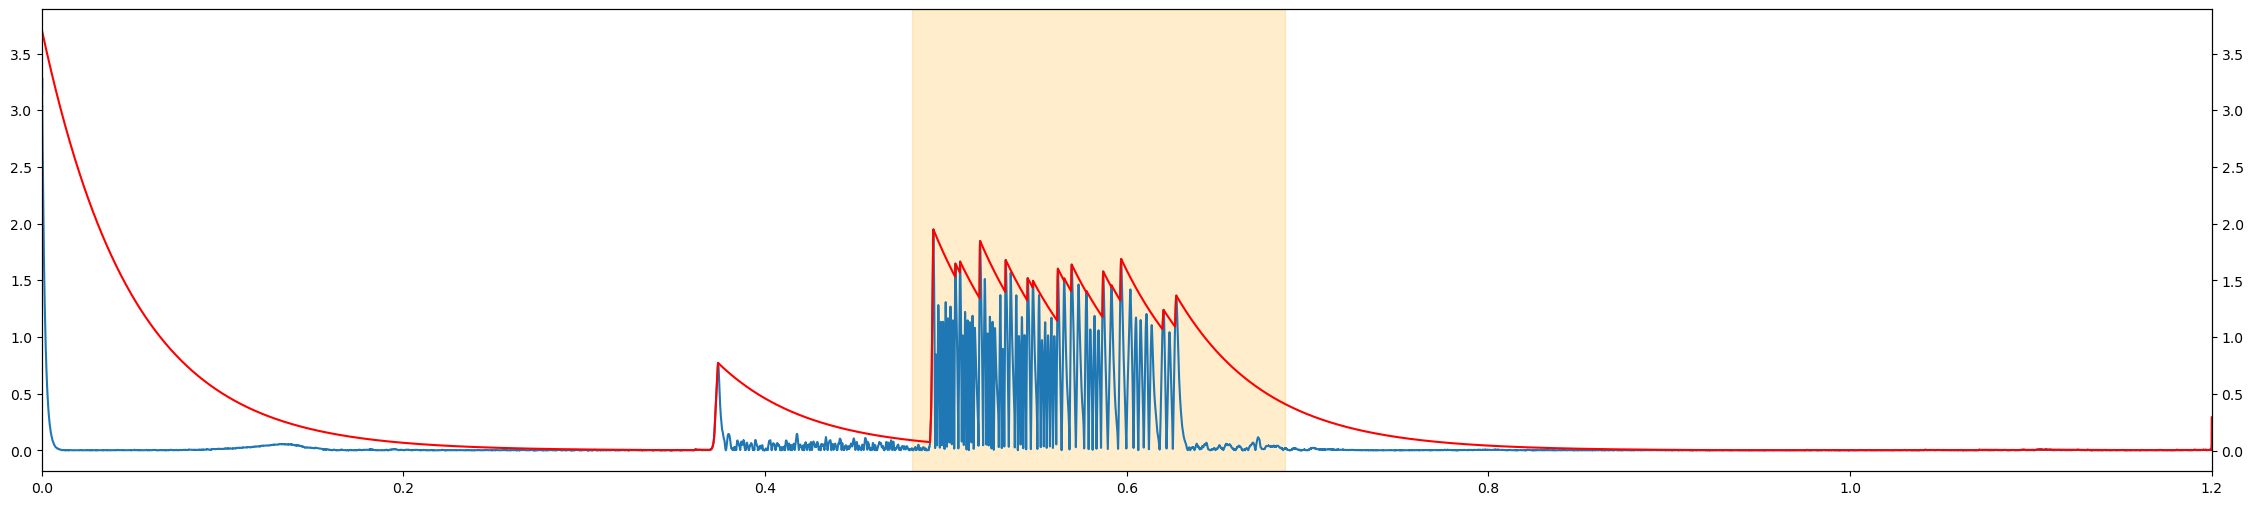

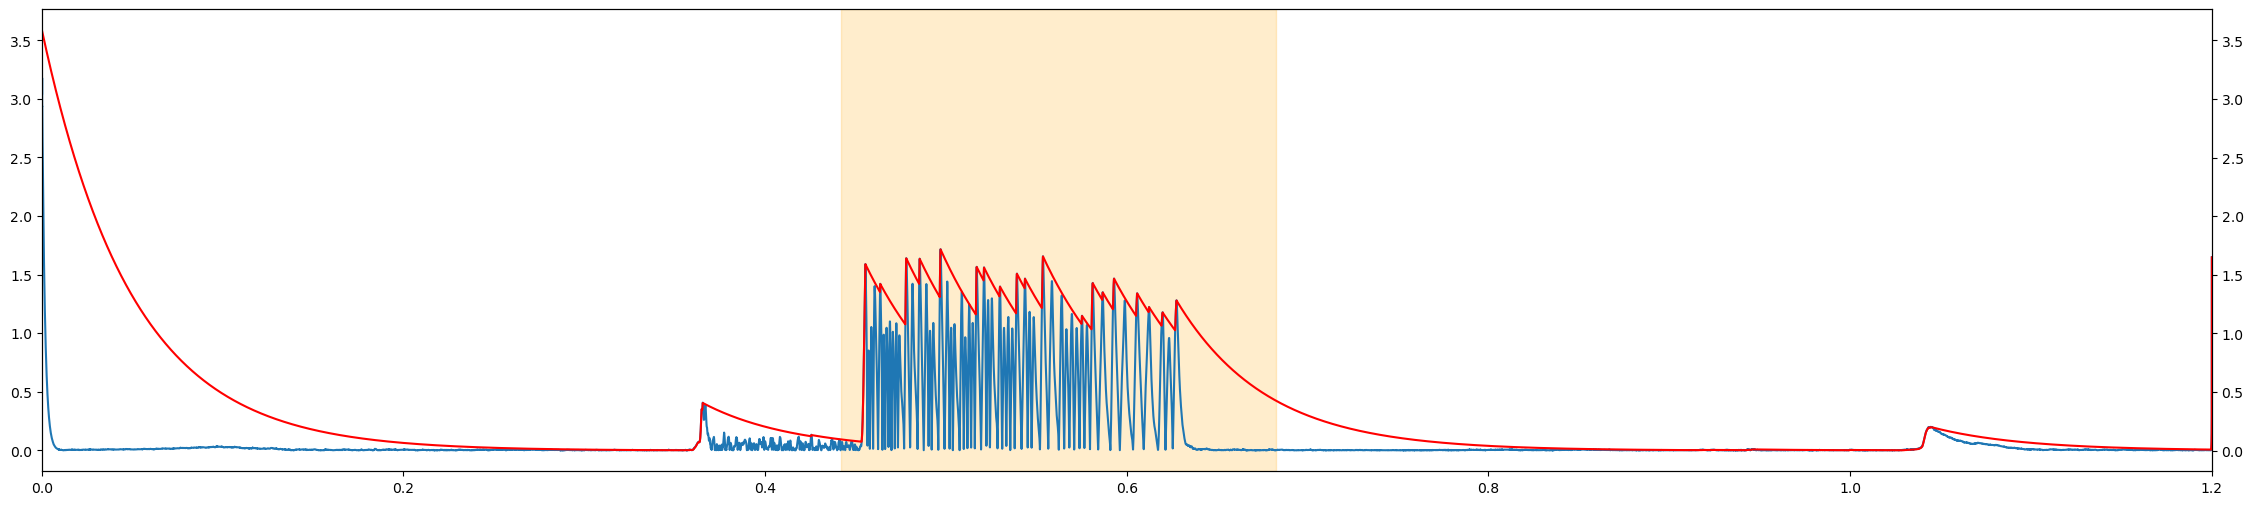

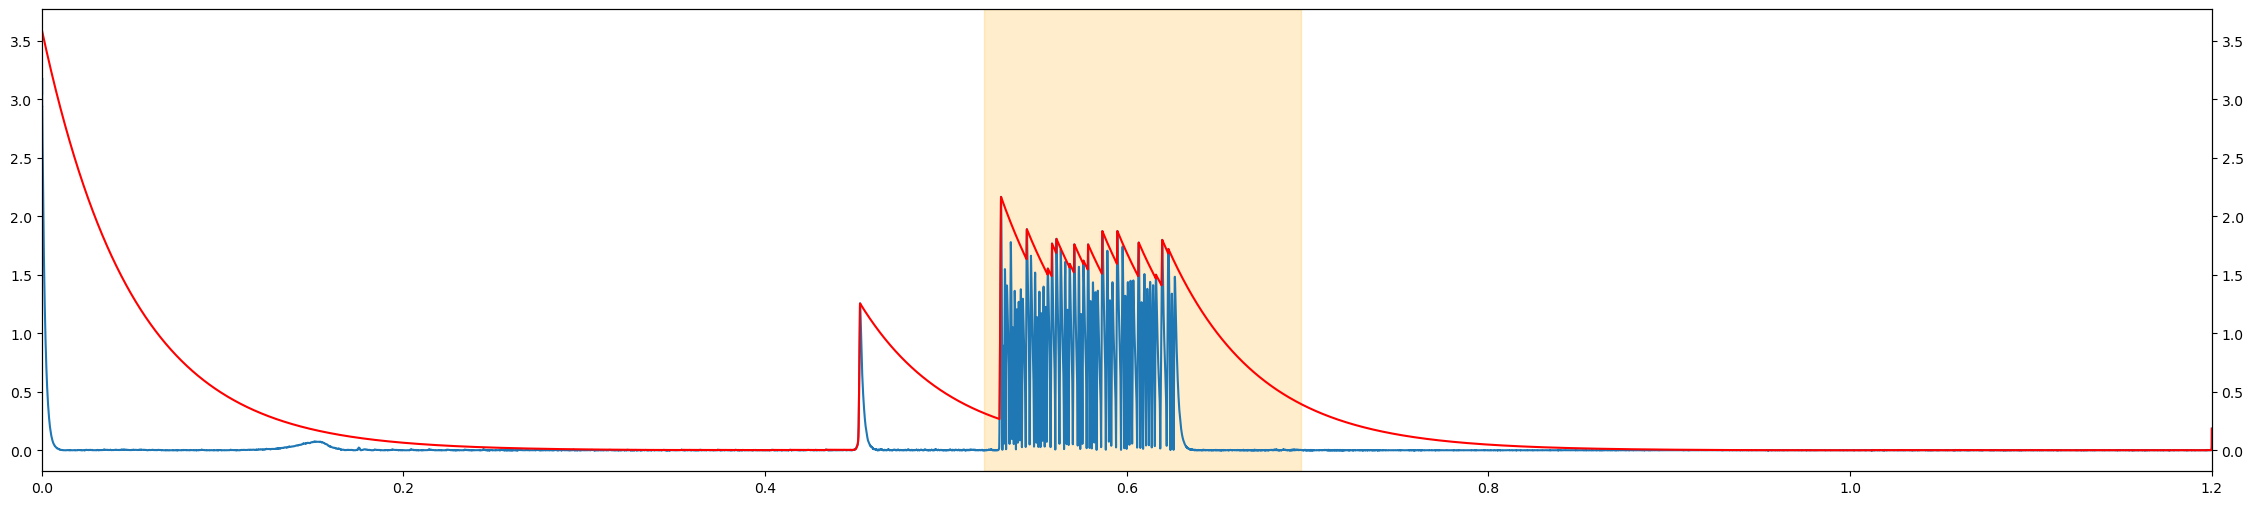

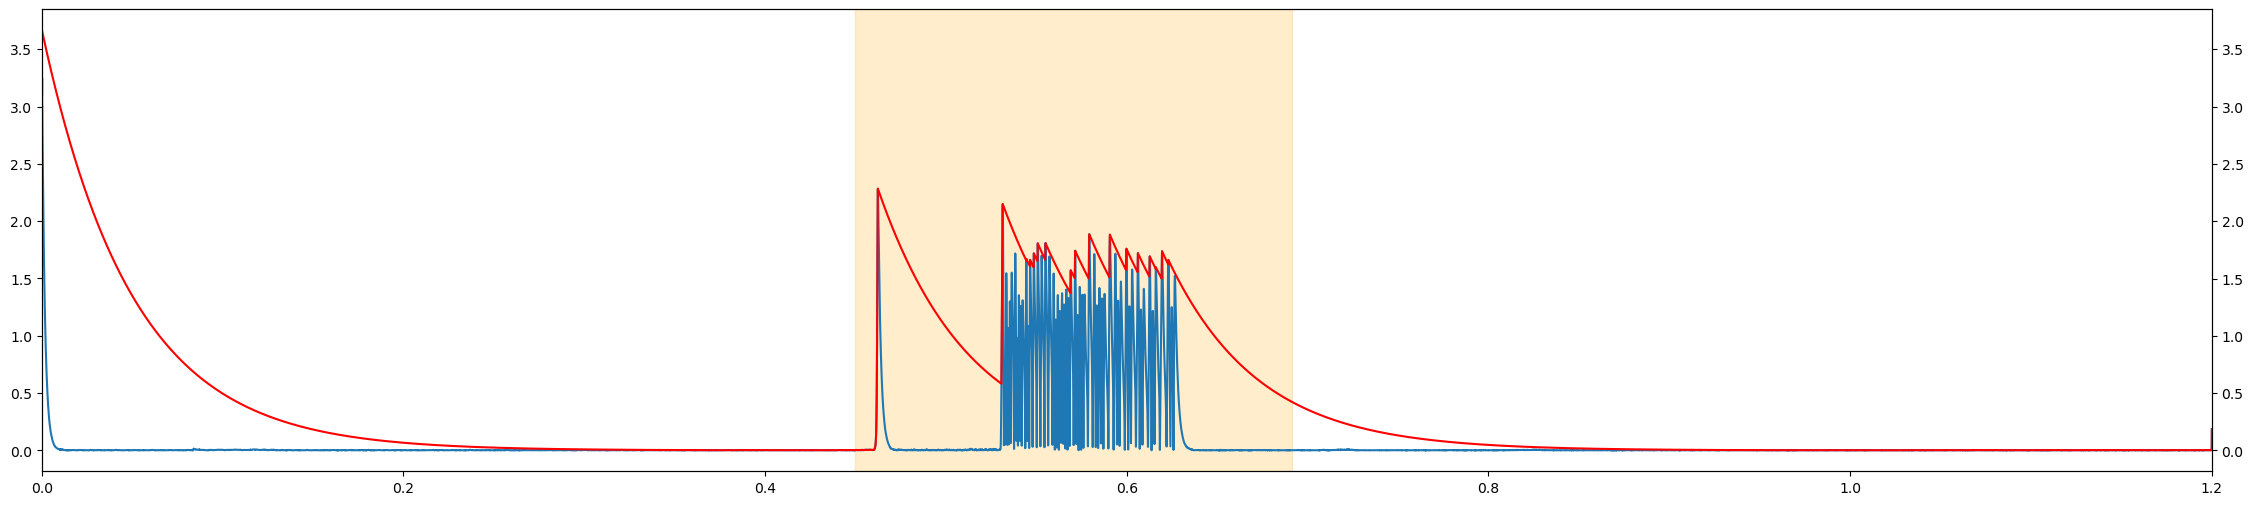

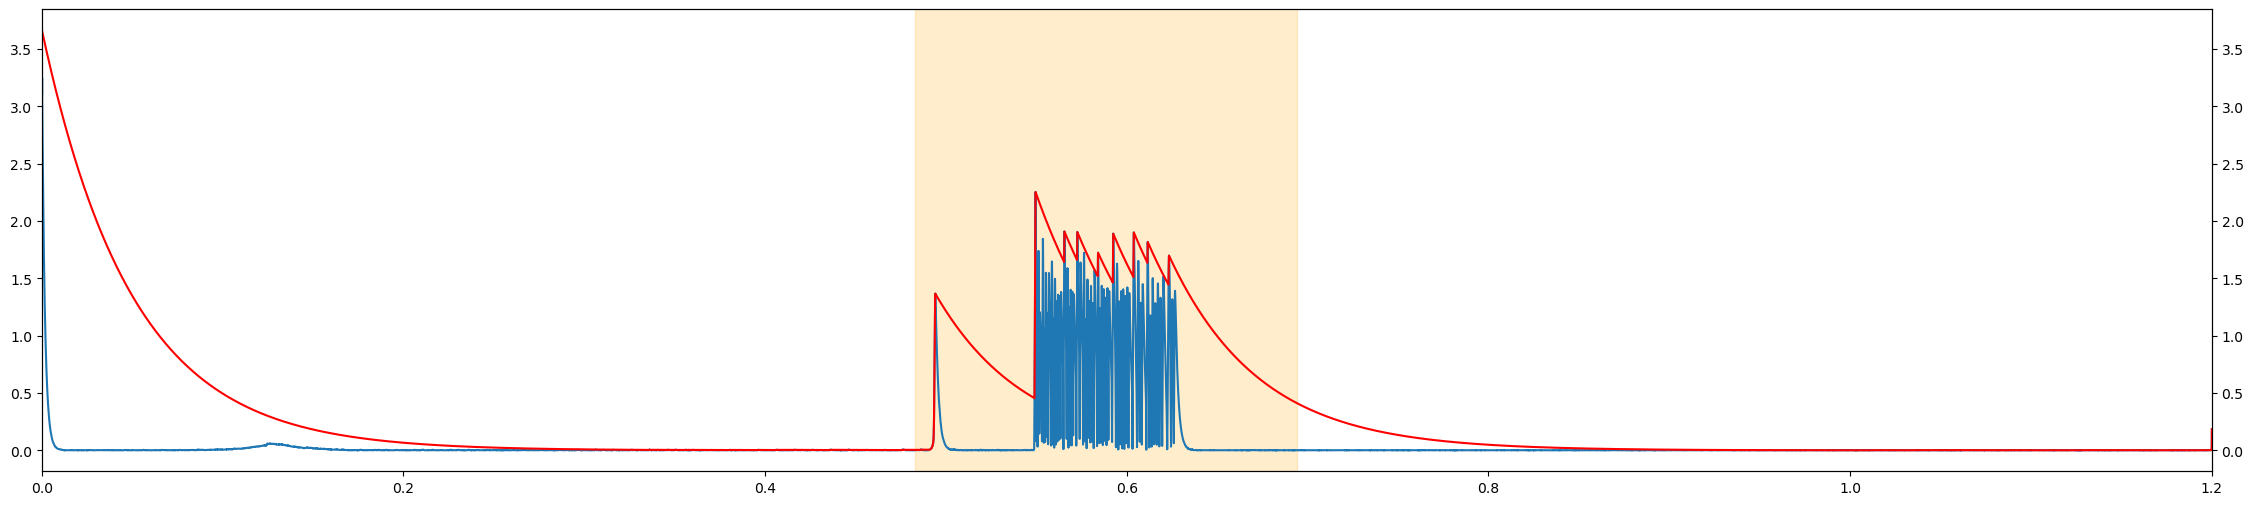

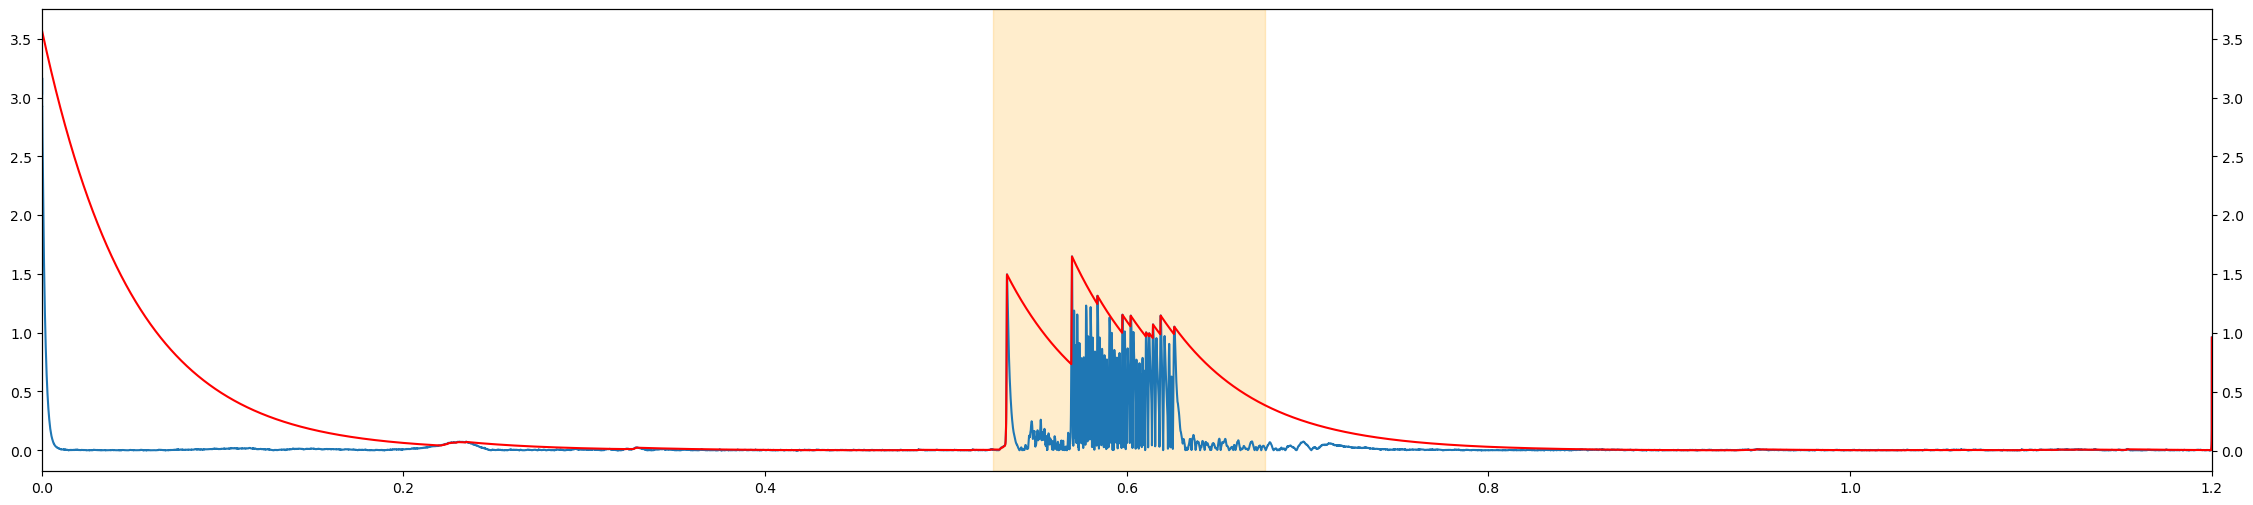

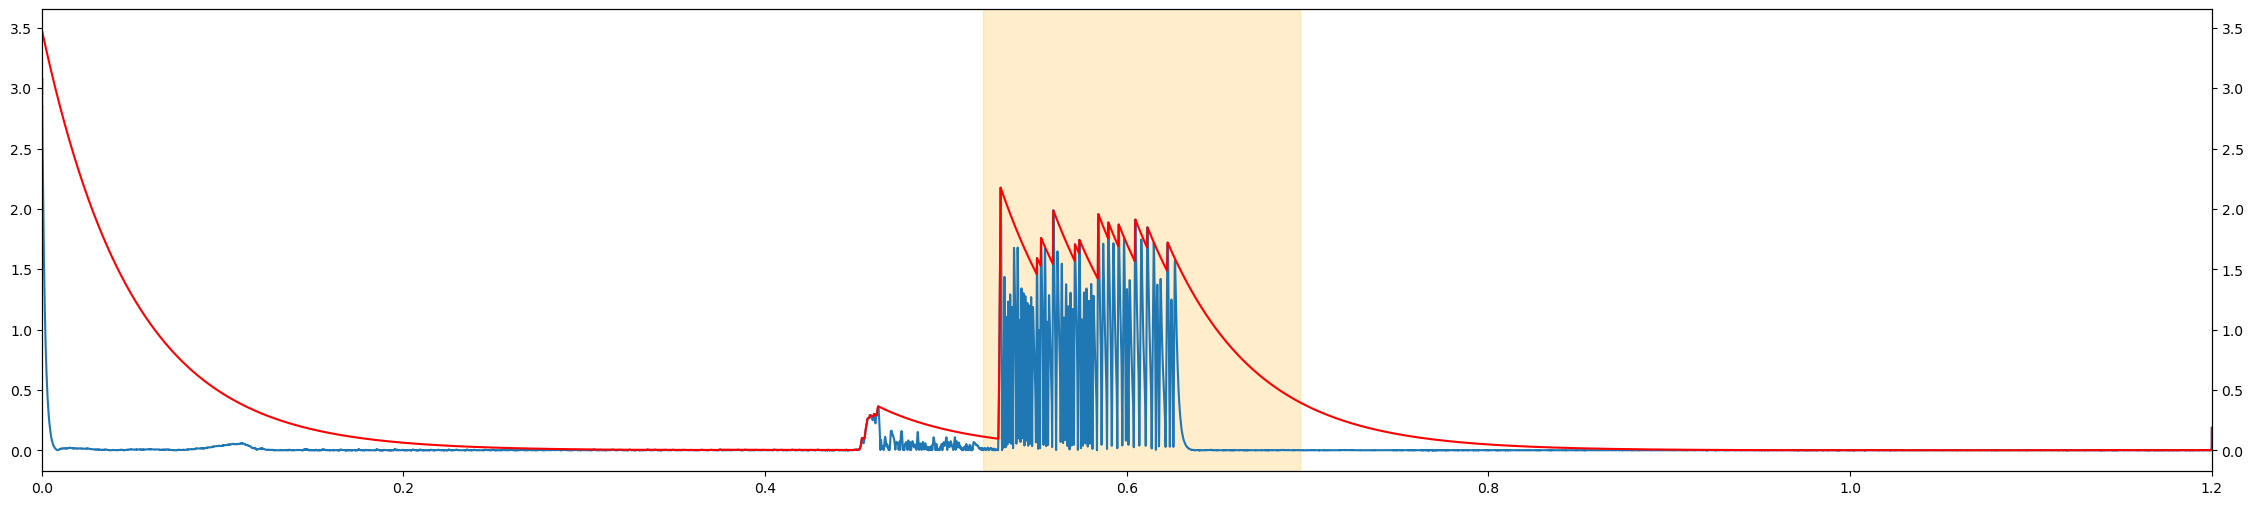

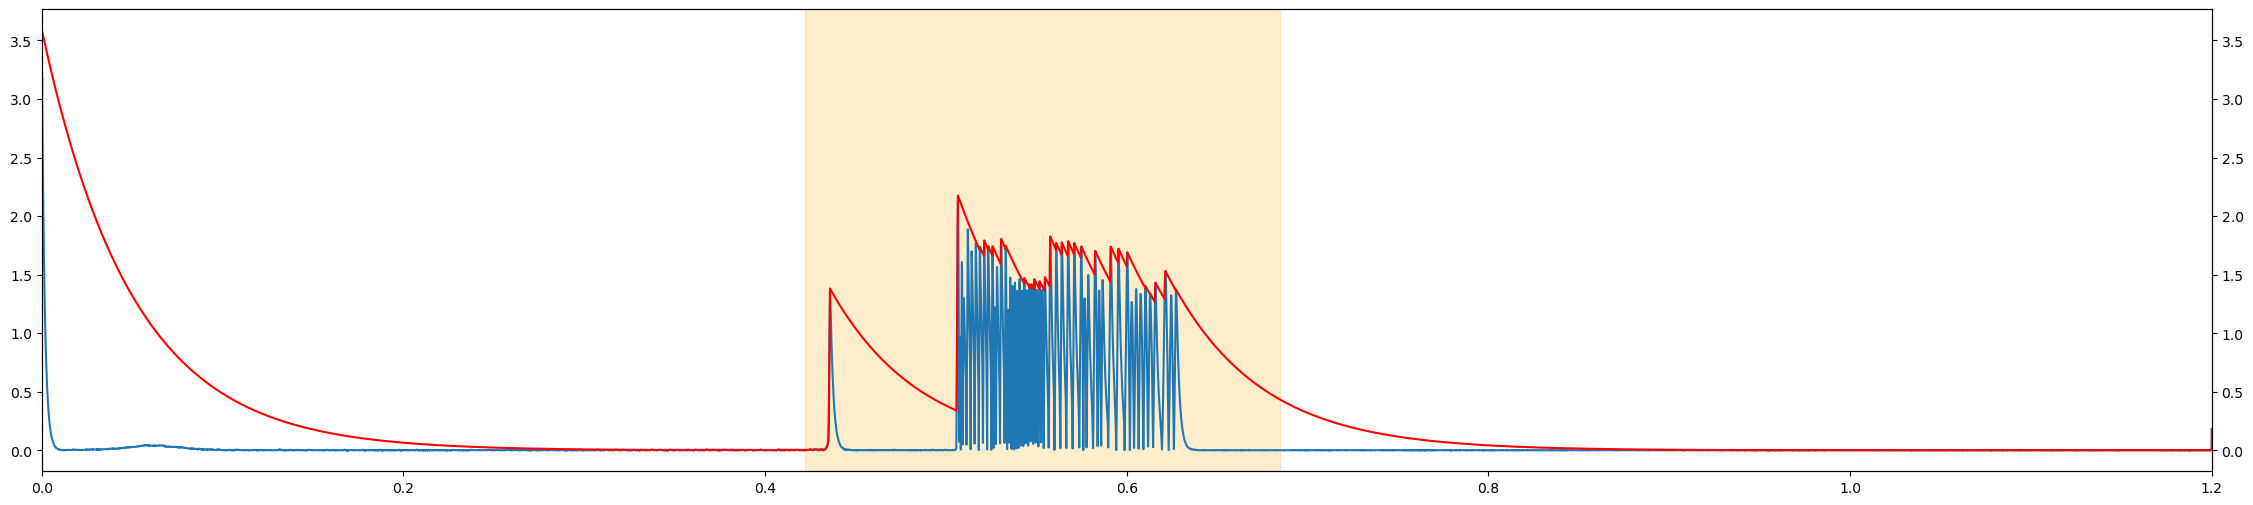

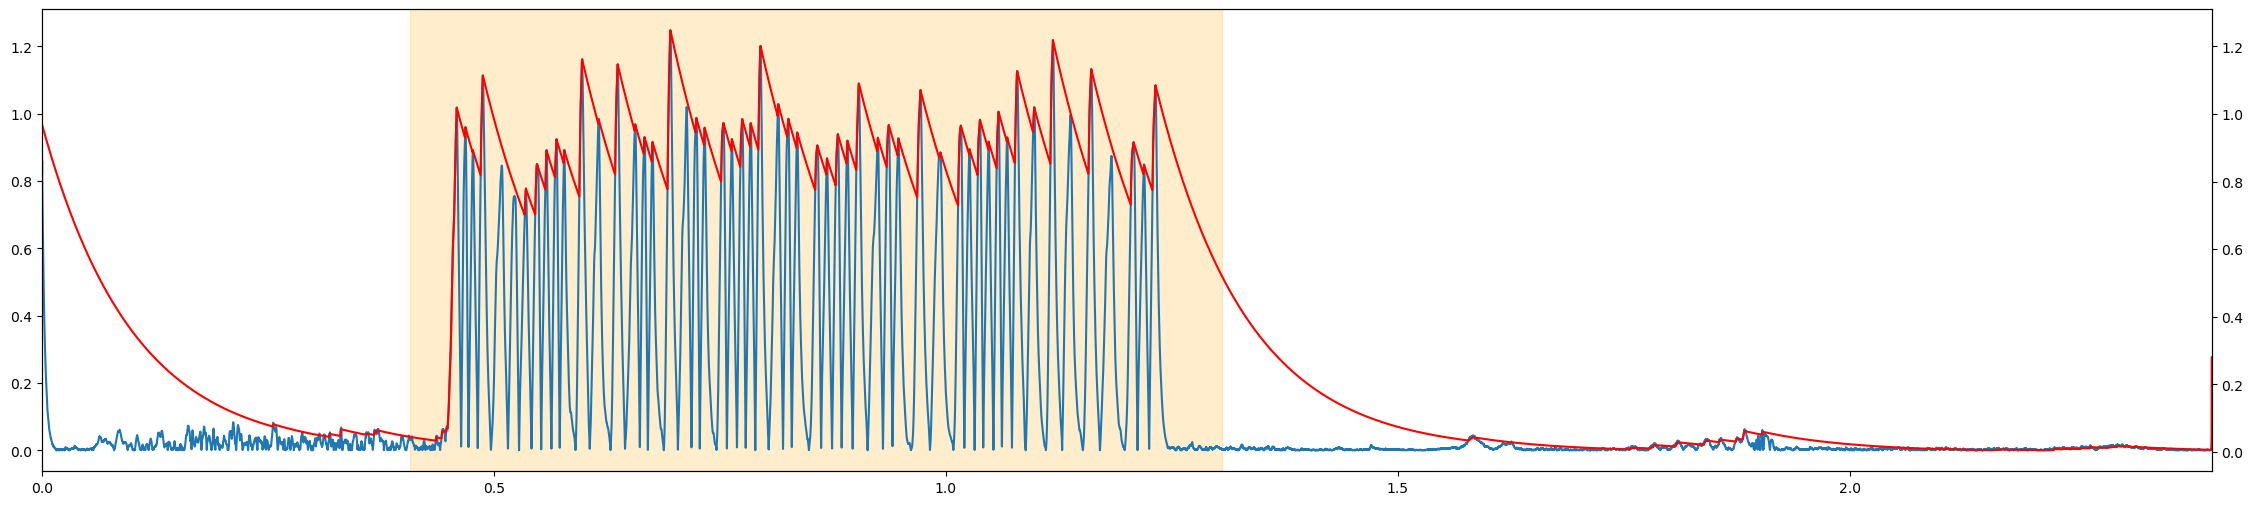

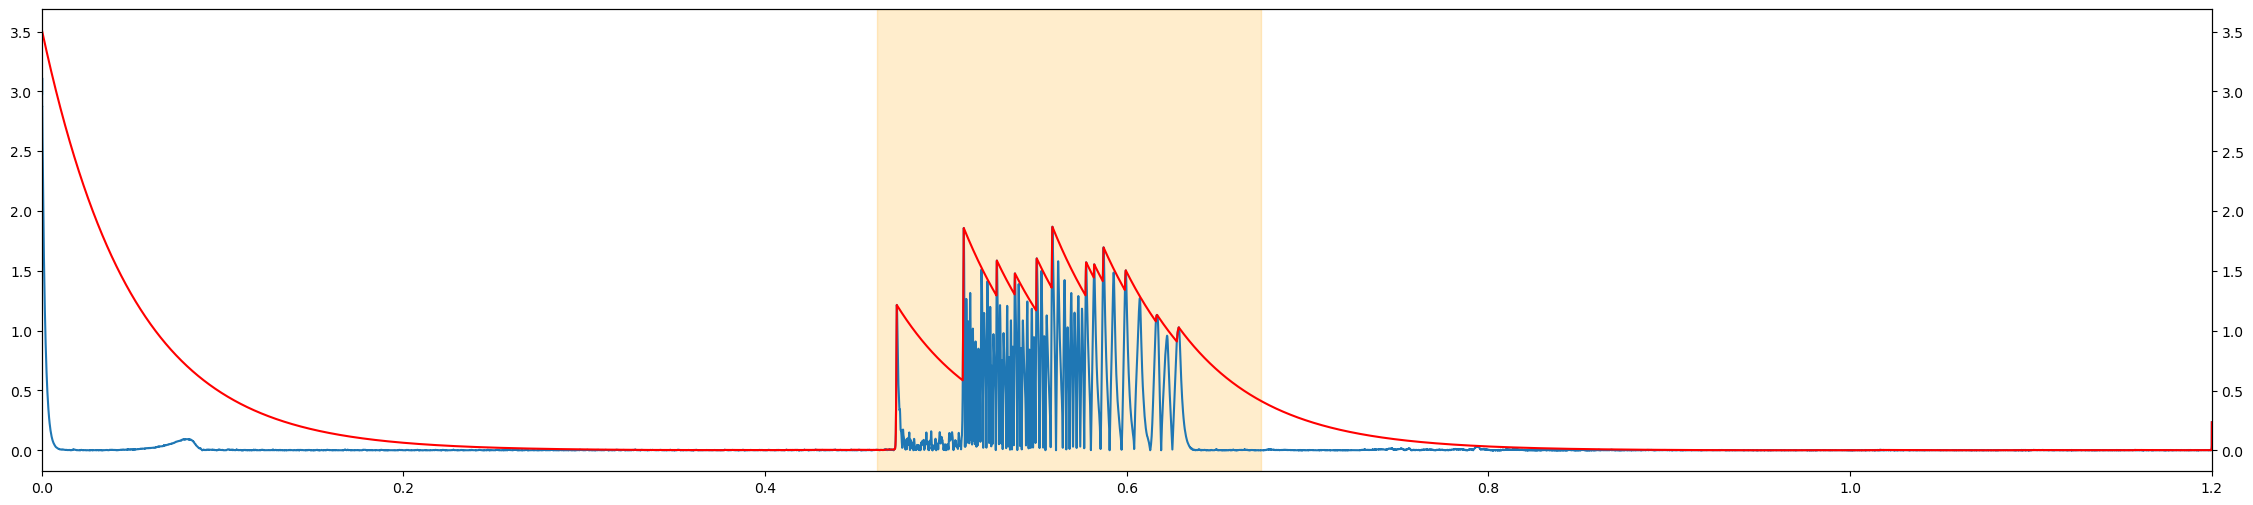

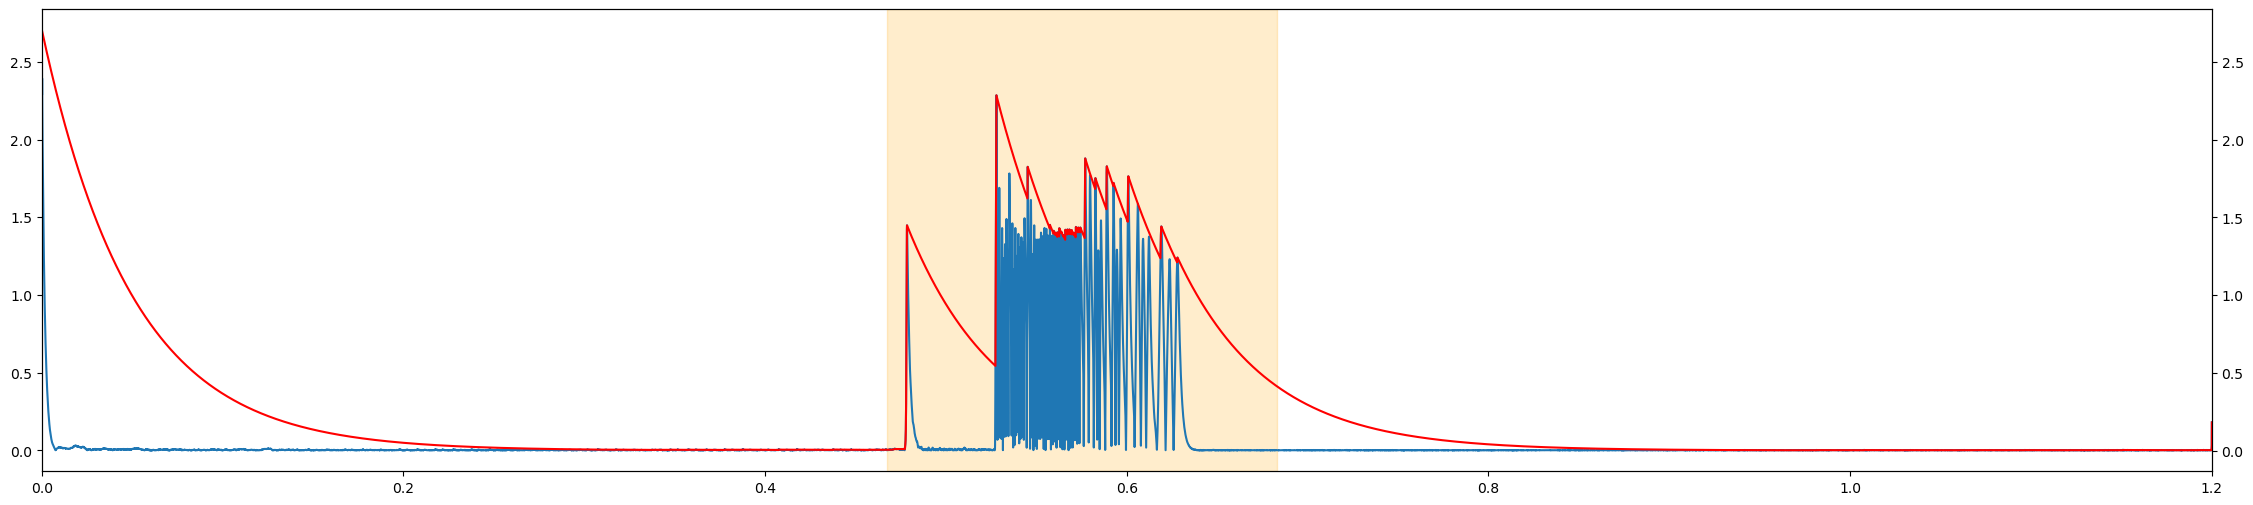

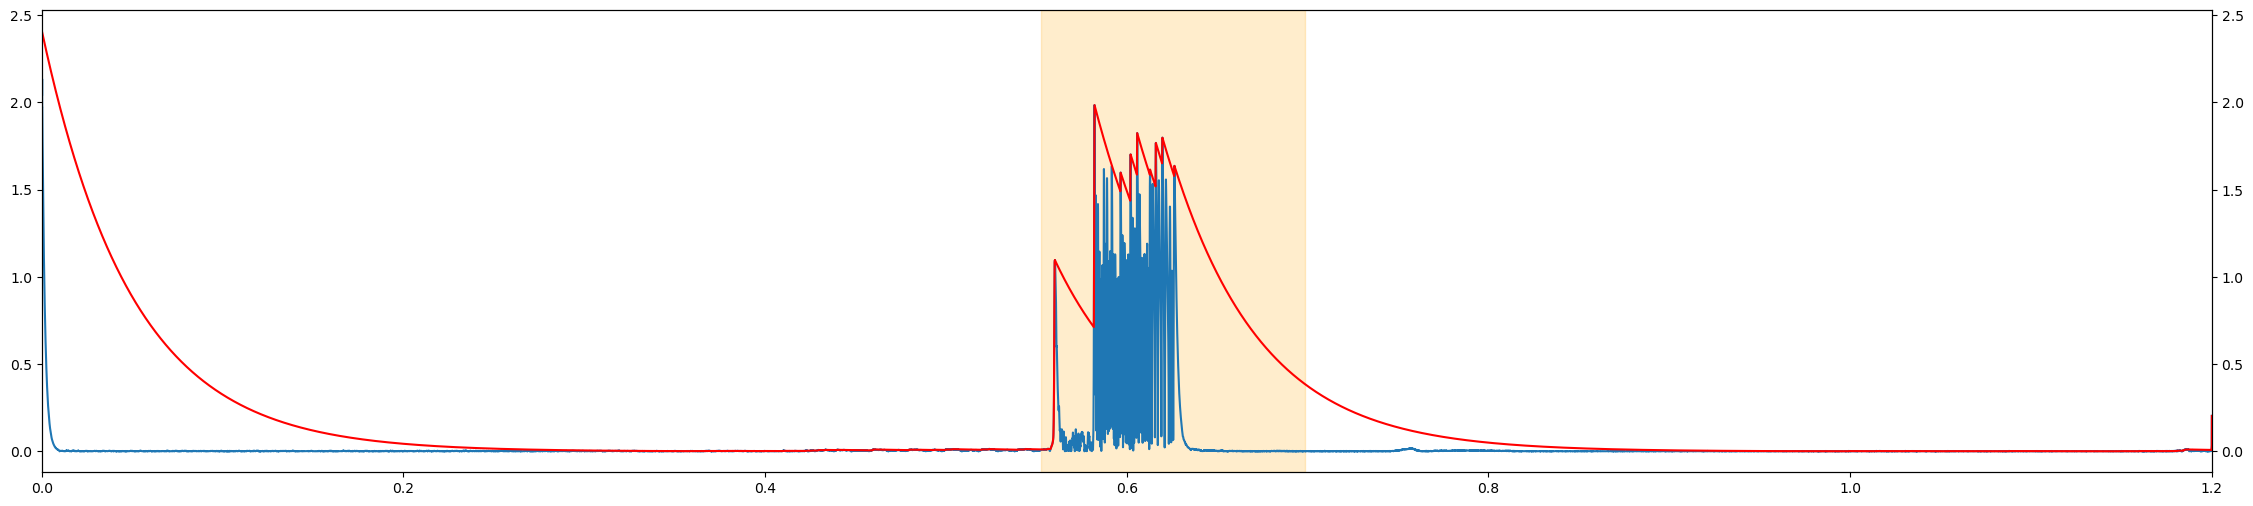

In [3]:
def find_signal(td, times, data):
    sos = sig.butter(1, 50, 'highpass', output='sos', fs=10e3)
    jitter = np.abs(sig.sosfilt(sos, data))
    
    def sweep(ys, coeff=0.999):
        out = np.zeros(ys.shape)
        acc = 0
        for i, y in enumerate(ys):
            if y > acc:
                acc = y
            else:
                acc *= coeff
            out[i] = acc
        return out
    
    loc = sweep(jitter)
    
    loc_th = 0.333
    sel = (loc > loc_th).astype(int)
    indices = np.squeeze(np.argwhere(sel[1:] - sel[:-1]))
    if sel[0]:
        indices = indices[1:]
    
    fig, ax = plt.subplots(figsize=(28, 6))
    ax.plot(times, jitter)
    ax.twinx().plot(times, loc, color='red')
    ax.set_xlim([times[0], times[-1]])
    
    largest_interval = 0.02 # Min interval length
    found_a, found_b = None, None
    for a, b in zip(indices[0::2], indices[1::2]):
        dt = times[b] - times[a]
        if dt < 1.5 and dt > largest_interval:
            largest_interval = dt
            d_idx = b - a
            guard_left, guard_right = 0.05, -0.05
            found_a, found_b = round(a - d_idx*guard_left), round(b + d_idx*guard_right)
    
    ax.axvspan(times[found_a], times[found_b], color='orange', alpha=.2, zorder=-3)
    return found_a, found_b

found_signals = [find_signal(*wf) for wf in wfs]
print(found_signals)

Edges ok, found 32 bits
Ref hex: 09abcde
Payload: 11100001000110111011110101110100
Ref enc: 11100001000110111011110101110100
         ................................
Reference decoding: 09abcde
Resuling data word: 09abcde
11100001000110111011110101110100

Edges ok, found 32 bits
Ref hex: 1234567
Payload: 00001010010011100111001011110101
Ref enc: 00001010010011100111001011110101
         ................................
Reference decoding: 1234567
Resuling data word: 1234567
00001010010011100111001011110101

Edges ok, found 32 bits
Ref hex: 30f0f0f
Payload: 00001011110101101100010010001111
Ref enc: 00001011110101101100010010001111
         ................................
Reference decoding: 30f0f0f
Resuling data word: 30f0f0f
00001011110101101100010010001111

Edges ok, found 32 bits
Ref hex: 1111111
Payload: 10001101010111110001000100110011
Ref enc: 10001101010111110001000100110011
         ................................
Reference decoding: 1111111
Resuling data word: 1111111
100011

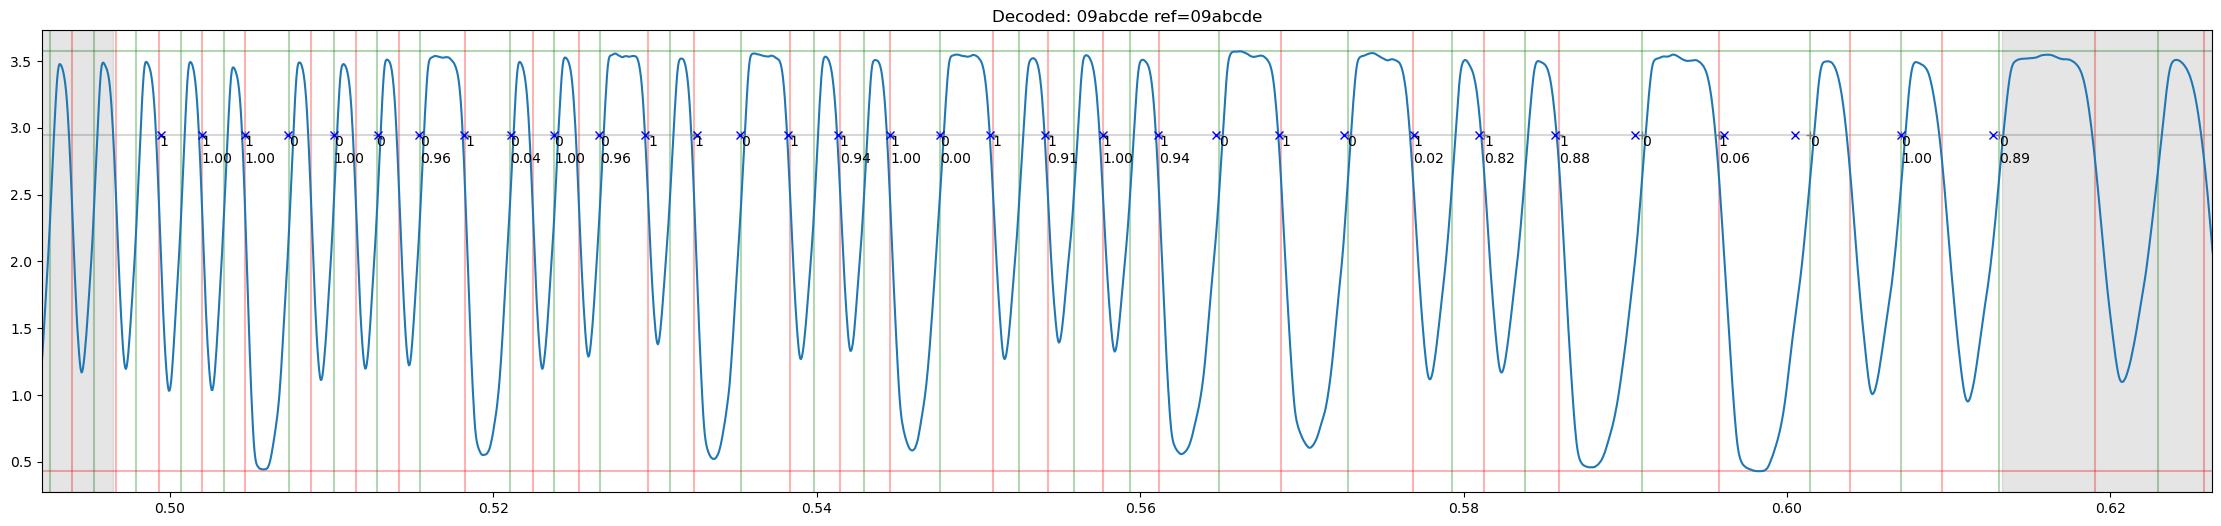

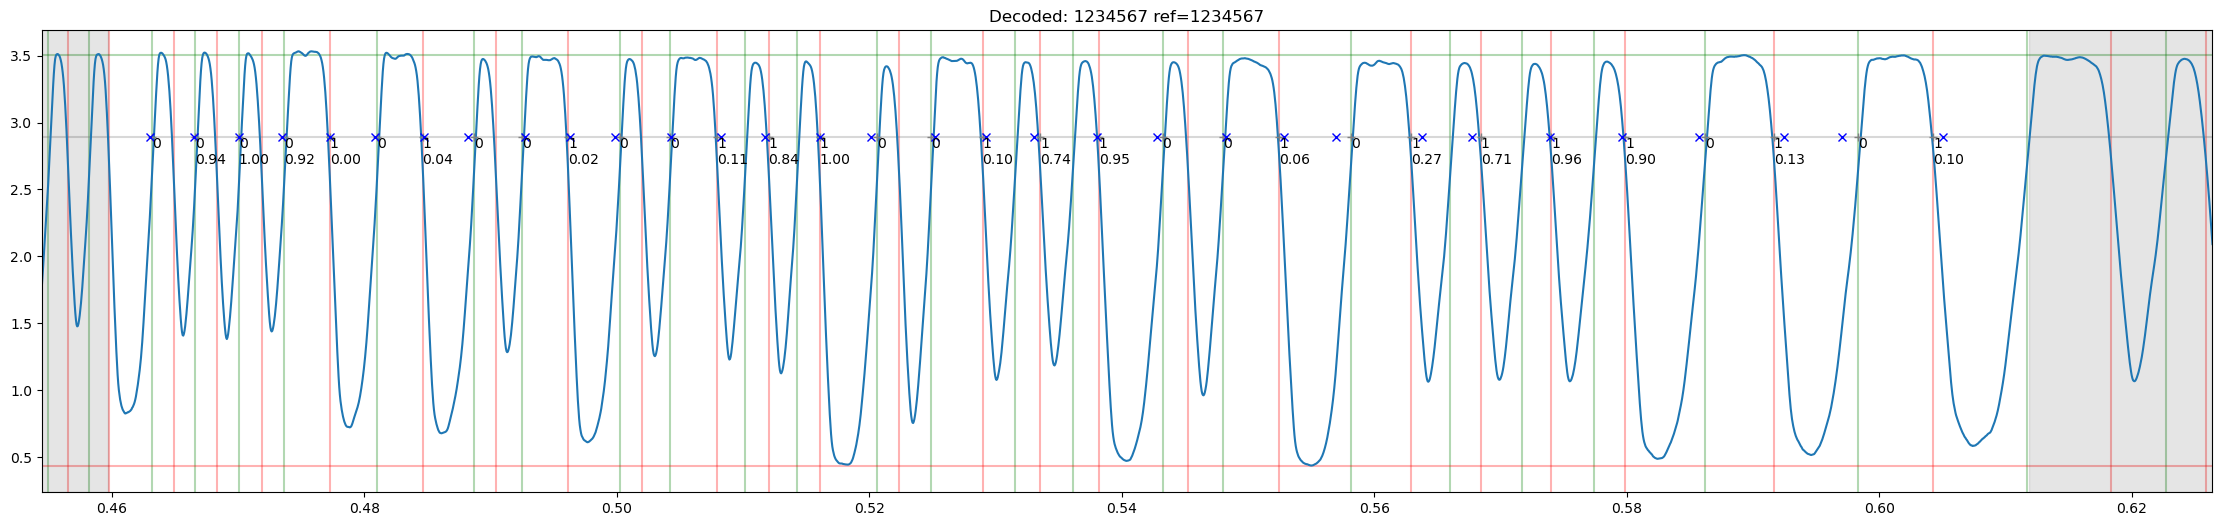

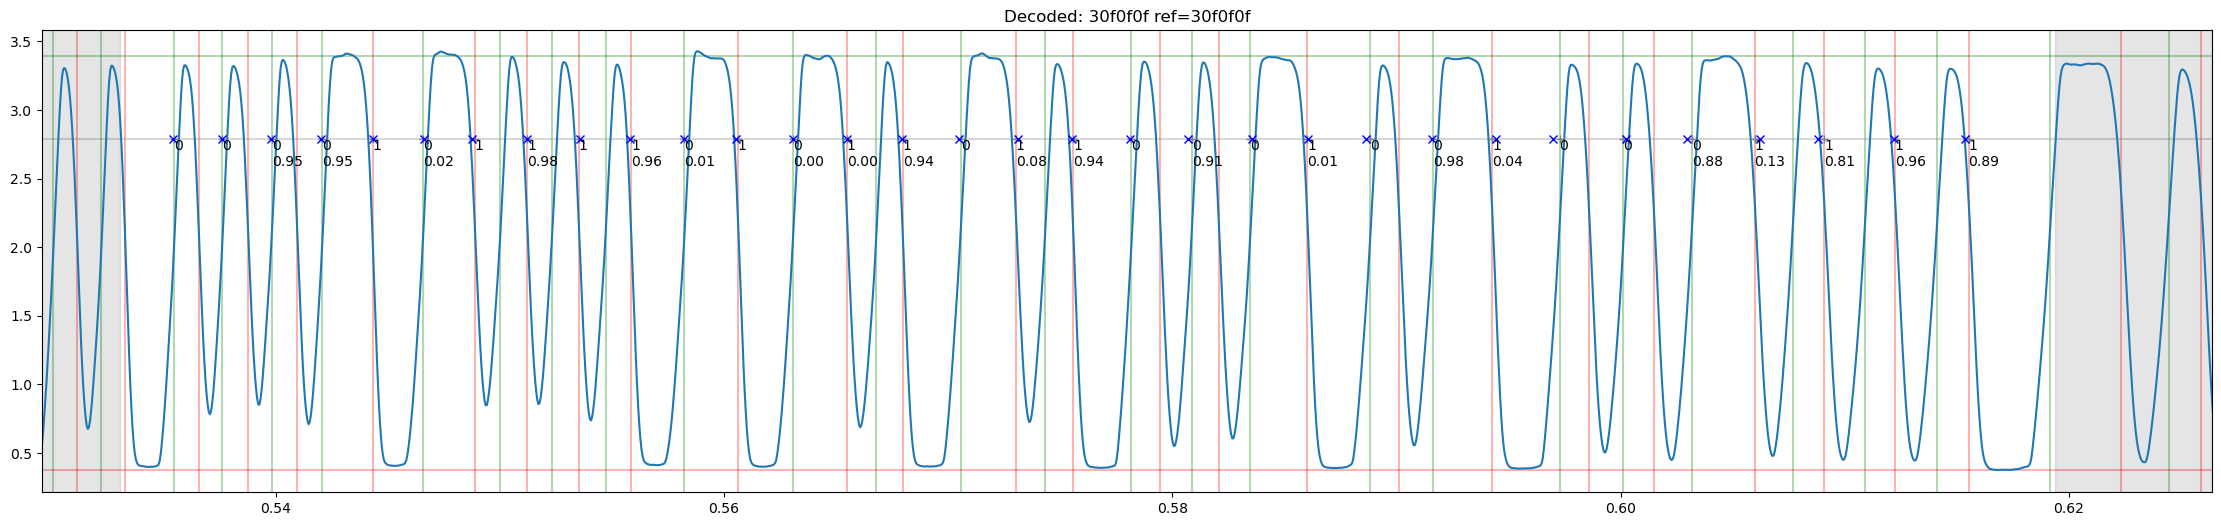

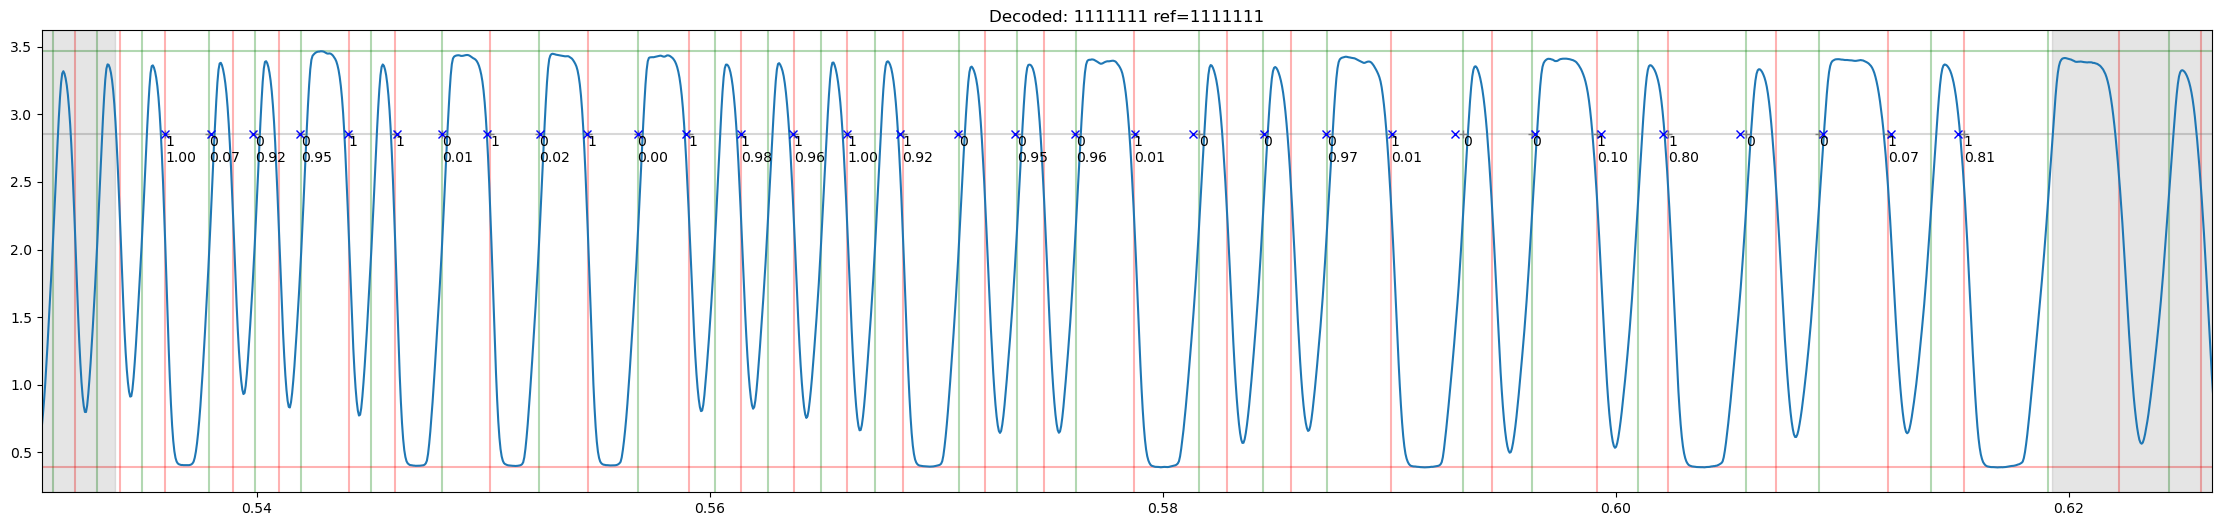

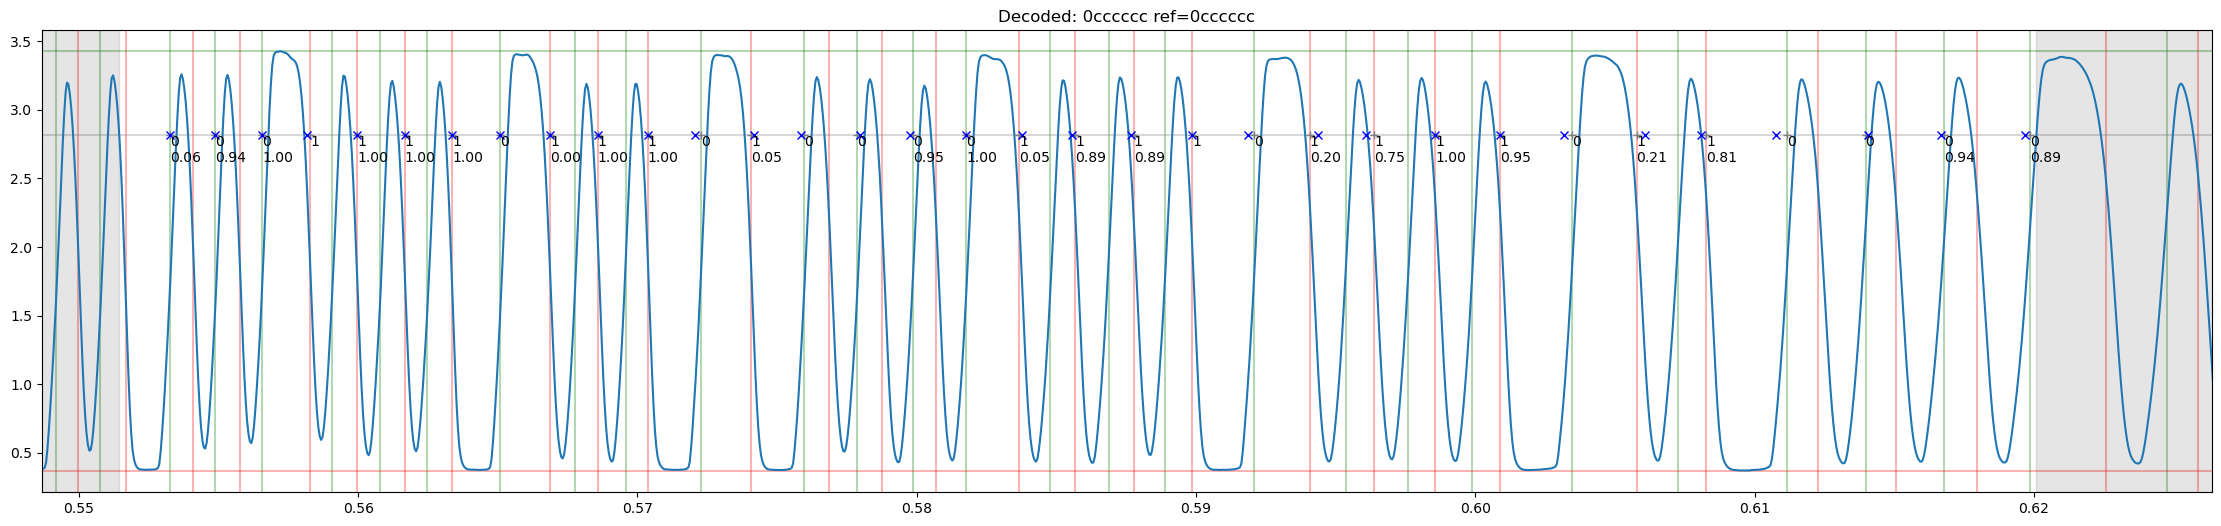

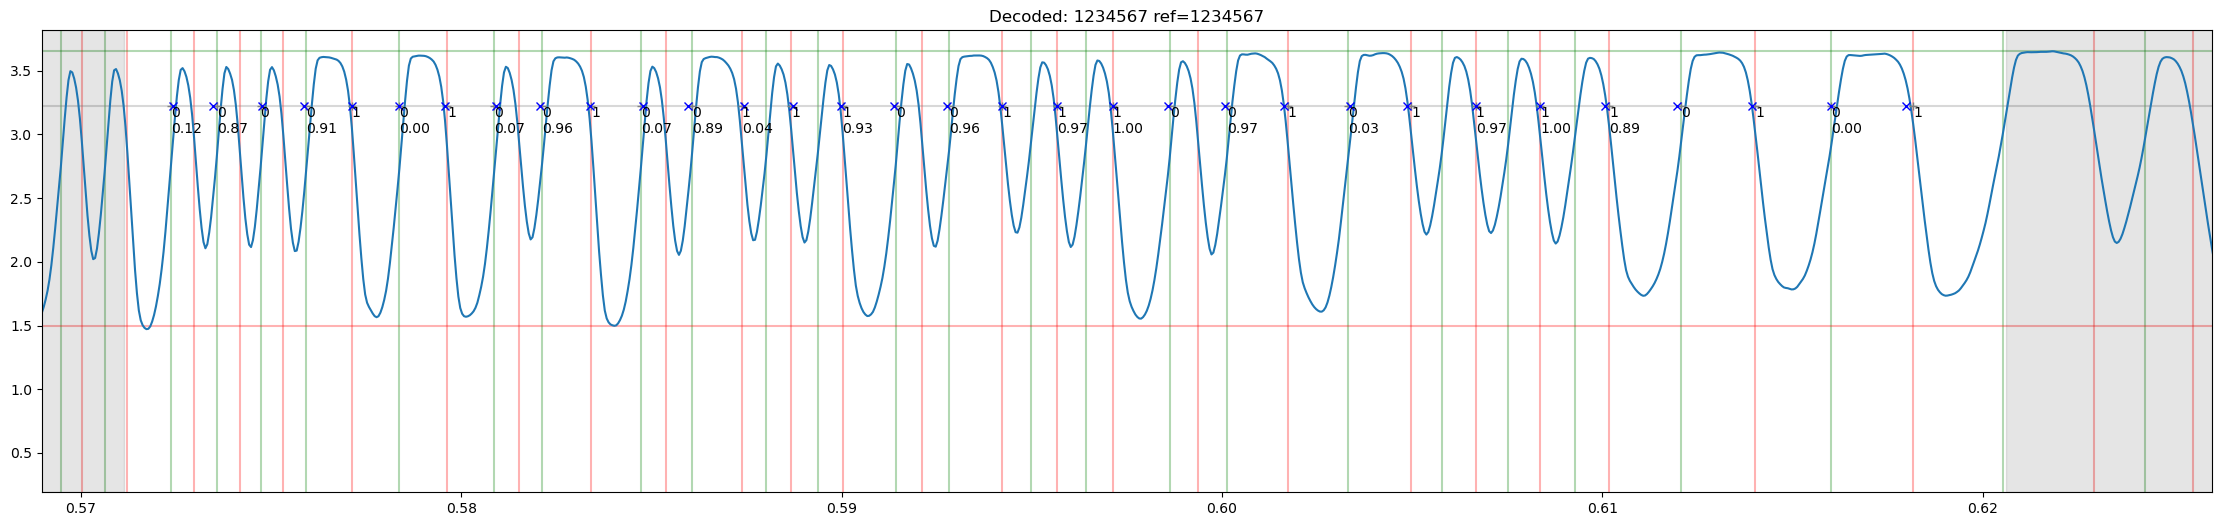

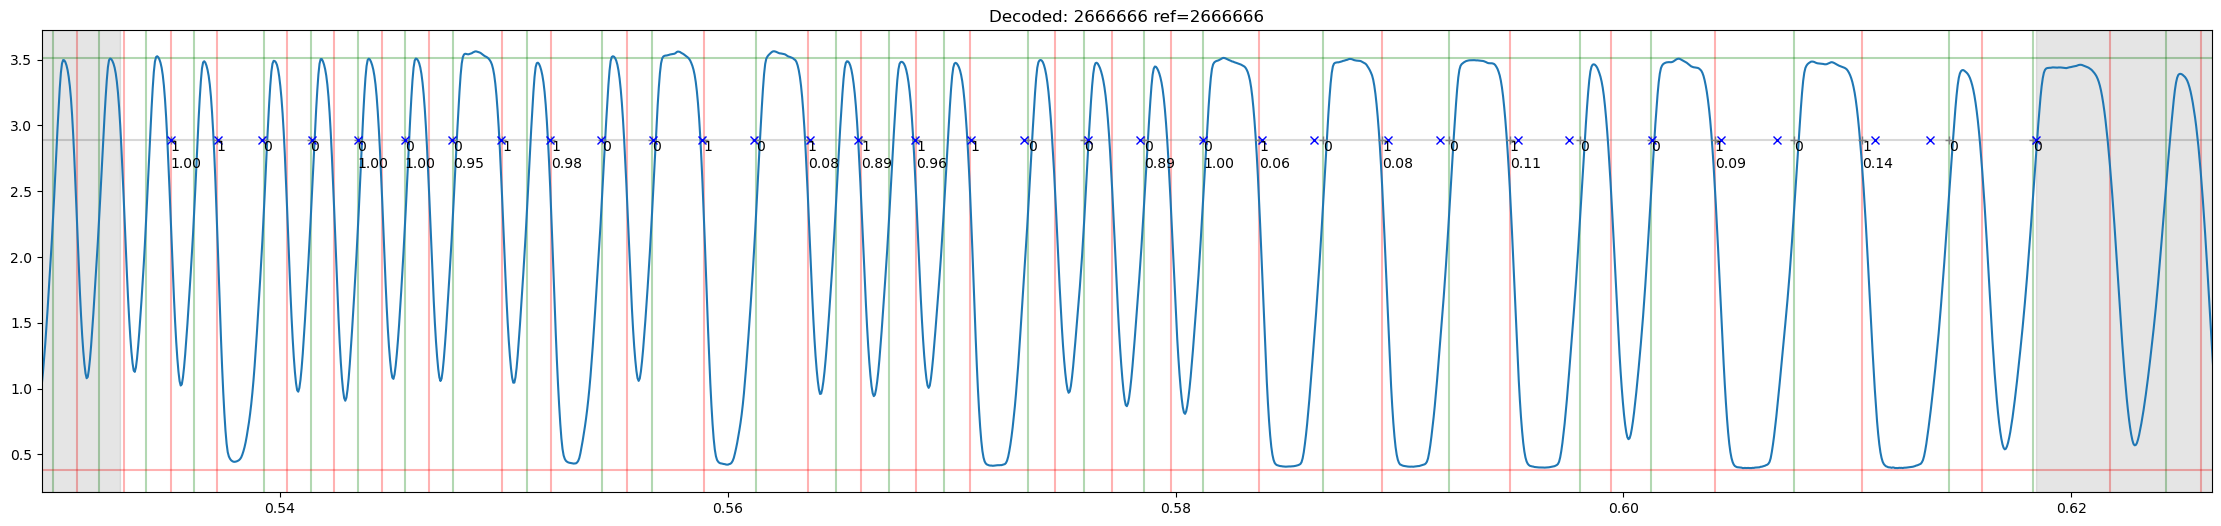

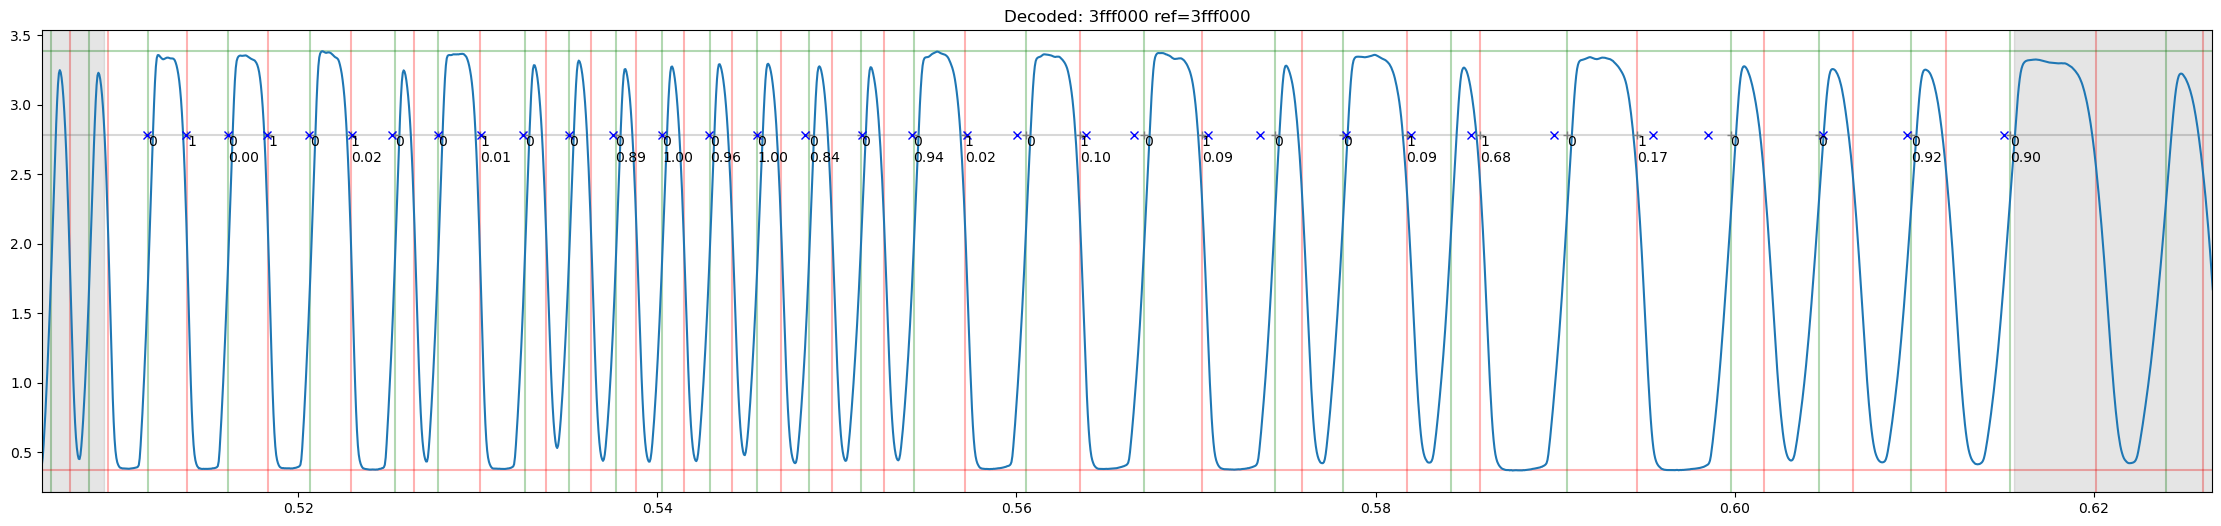

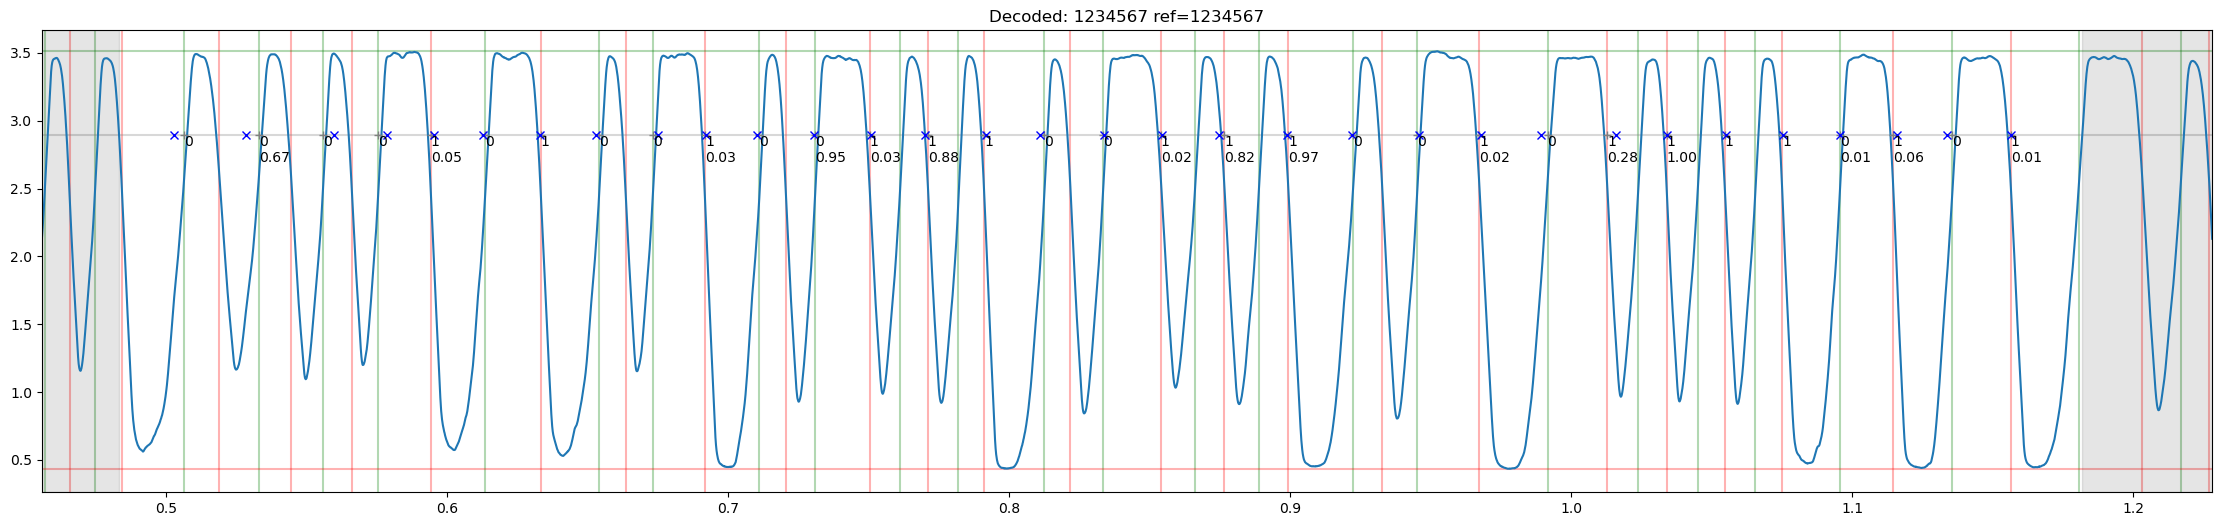

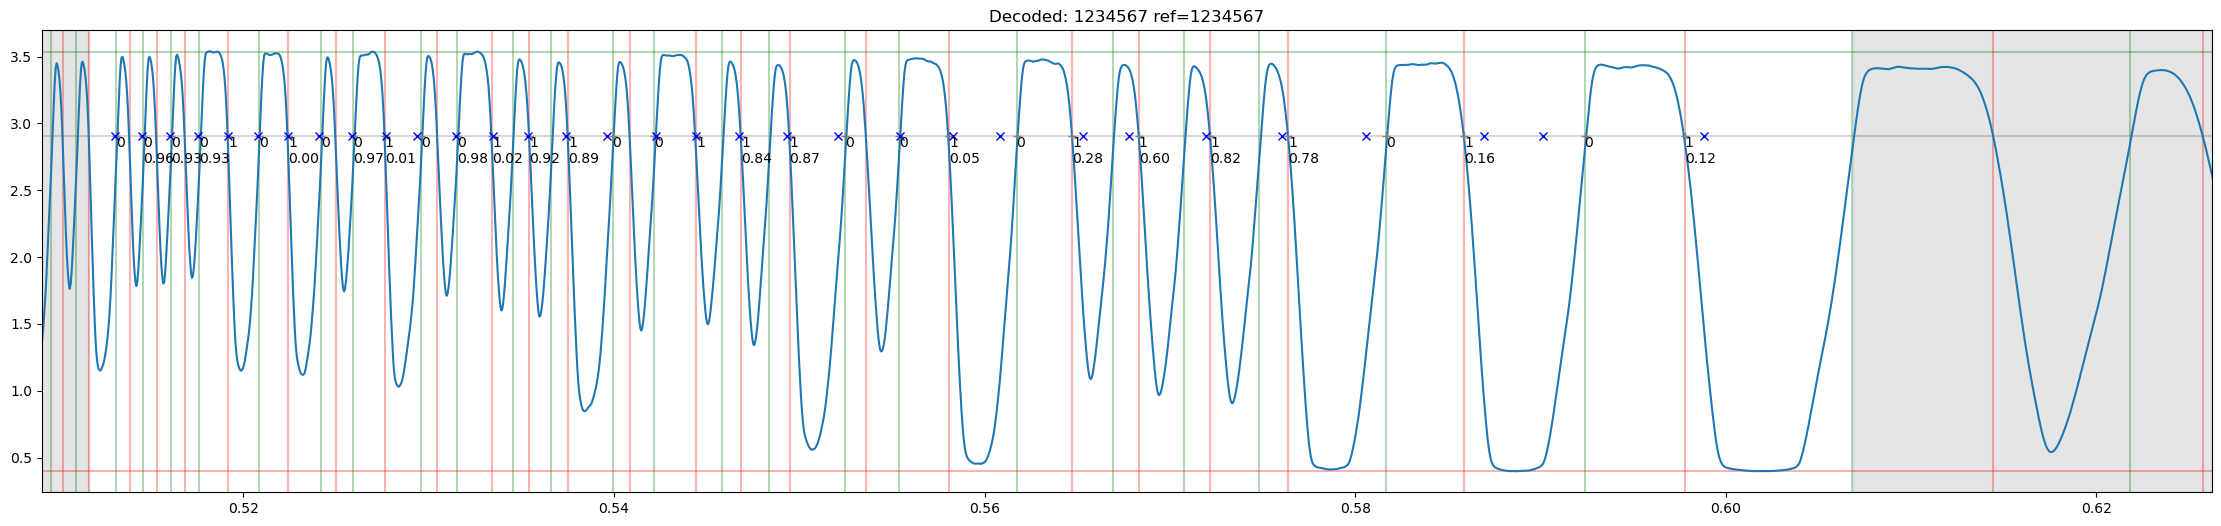

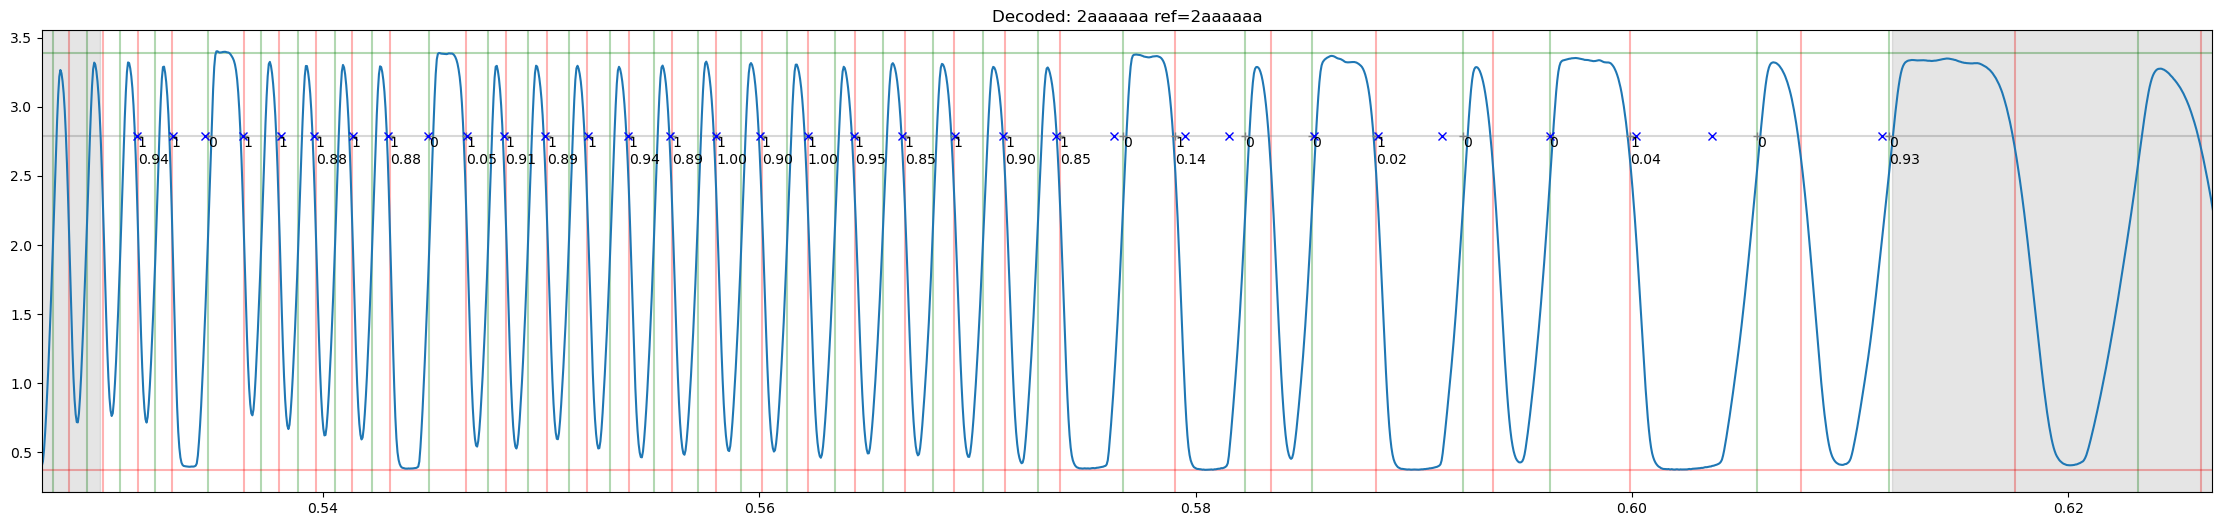

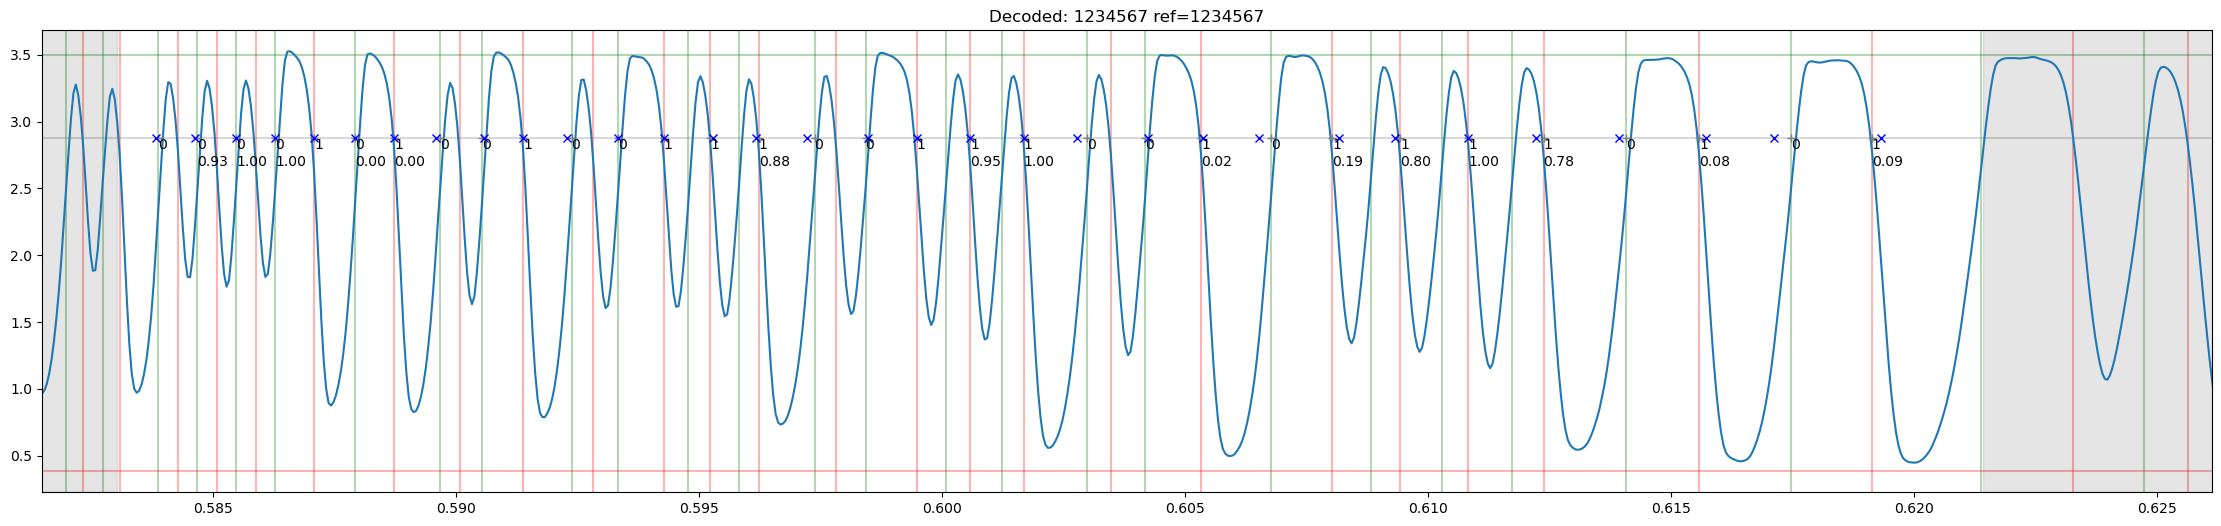

In [4]:
def decode_bits(ax, data, times, found, ref):
    found_a, found_b = found
    d, t = data[found_a:found_b], times[found_a:found_b]
    ax.plot(t, d)
    ax.set_xlim([t[0], t[-1]])

    subslice = d[len(d)//2 - len(d)//6:len(d)//2 + len(d)//6]
    low, high = subslice.min(), subslice.max()
    amp = high - low
    # use slightly more than one half to account for the fact that we don't quite go dark during narrow black lines due to our detector's slit width
    th = low + amp*0.8
    ax.axhline(low, color='red', alpha=0.3, zorder=-3)
    ax.axhline(high, color='green', alpha=0.3, zorder=-3)
    ax.axhline(th, color='gray', alpha=0.3, zorder=-3)

    # Find edges
    bits = (d > th).astype(int)
    edges = np.argwhere(bits[1:] - bits[:-1])[:,0].astype(float)
    intervals = edges[1:] - edges[:-1]
    
    # Remove leading or trailing garbage
    mean_ref = intervals[len(intervals)//2 - len(intervals)//6:len(intervals)//2 + len(intervals)//6].mean()
    
    for i, x in enumerate(intervals):
        if 0.1 < x/mean_ref < 10:
            break
    intervals = intervals[i:]
    edges = edges[i:]
    
    for i, x in enumerate(intervals[::-1]):
        if 0.1 < x/mean_ref < 10:
            break
    if i>0:
        intervals = intervals[:-i]
        edges = edges[:-i]

    # Find orientation
    ratio_left = abs(intervals[2]/intervals[0] - 1)
    ratio_right = abs(intervals[-3]/intervals[-1] - 1)
    
    if ratio_left > ratio_right:
        # We're backwards, reverse data.
        print('Scan reversed')
        d, t = d[::-1], t[::-1]
        edges = len(d)-edges[::-1]
        intervals = intervals[::-1]

    ax.axvspan(t[0], t[round(edges[3])], color='black', alpha=.1, zorder=-3)
    ax.axvspan(t[round(edges[-4])], t[-1], color='black', alpha=.1, zorder=-3)
        
    # Slew rate correction
    d_slew = (intervals[0] - intervals[1]) / 2
    edges[0::2] += d_slew/2
    edges[1::2] -= d_slew/2
    intervals = edges[1:] - edges[:-1]

    for i, x in enumerate(edges):
        new_value = not i%2
        ax.axvline(t[round(x)], color=('green' if new_value else 'red'), alpha=0.3, zorder=-5)
    
    ax.set_xlim([t[round(edges[0]-10)], t[round(edges[-1]+10)]])

    # Edge matching
    bits = []
    last_edge = 3
    last_interval = edges[3] - edges[1]
    
    while last_edge < len(edges) - 5: # While we have not reached the right marker
        expected_next_edge = edges[last_edge] + last_interval
        a, b = edges[last_edge+1:last_edge+3]
        #print(f'{last_edge=}@{edges[last_edge]} w/ ivl={last_interval} | {expected_next_edge=} with candidates {a=} / {b=}')
        
        old_last_edge = last_edge
        if b < expected_next_edge:
            last_edge += 2
        elif expected_next_edge < a:
            last_edge += 1
        else: # a is left of expected next edge, b is right
            ratio = (expected_next_edge-a) / (b-a)
            if ratio > 0.3:
                last_edge += 2
            else:
                last_edge += 1
            ax.text(t[round(edges[last_edge])], th, f'\n{ratio:.2f}', verticalalignment='top', horizontalalignment='left')

        last_interval = edges[last_edge] - edges[old_last_edge]
        bits.append(last_edge%2) # last_edge%2 corresponds to the polarity of the edge, which corresponds to the value of our manchester-encoded bit.
        ax.plot(t[round(edges[last_edge])], th, marker='+', color='gray')
        ax.plot(t[round(expected_next_edge)], th, marker='x', color='blue')
        ax.text(t[round(edges[last_edge])], th, str(bits[-1]), verticalalignment='top', horizontalalignment='left')

    if len(bits) == 33:
        bits = bits[:32]

    ref = int(ref, 16) & 0x3ffffff
    ref = f'{ref:07x}'
    if len(bits) == 32:
        print(f'Edges ok, found {len(bits)} bits')
        print('Ref hex:', ref)
        print('Payload:', ''.join(map(str, bits)))
        
        rm = ReedMuller(3, 5)
        
        ref_val = int(ref, 16)
        ref_bits = [int(bool(ref_val&(2**i))) for i in range(26)]
        ref_encoded = rm.encode(ref_bits)
        print('Ref enc:', ''.join(map(str, ref_encoded)))
        print('        ', ''.join(('.' if a == b else '#') for a, b in zip(bits, ref_encoded)))

        ref_dec = rm.decode(ref_encoded)
        d_out = sum(2**i for i, x in enumerate(ref_dec) if x)
        print(f'Reference decoding: {d_out:07x}')
        
        #bits = [int(bool(0x1234567&(2**i))) for i in range(26)]
        #bits = rm.encode(bits)
        decoded = rm.decode(bits)
        if decoded is None:
            print('Reed-Muller decoding error')
            ax.set_title(f'Reed-Muller decoding error, ref={ref}')
        else:
            d_out = sum(2**i for i, x in enumerate(decoded) if x)
            print(f'Resuling data word: {d_out:07x}')
            ax.set_title(f'Decoded: {d_out:07x} ref={ref}')
    else:
        print(f'Framing error, found {len(bits)} bits instead of 32')
        ax.set_title(f'Framing error {len(bits)}, ref={ref}')

    return bits

found_bits = []
for (td, times, data), found, ref in zip(wfs, found_signals, ref_data):
    fig, ax = plt.subplots(figsize=(28, 6))
    bits = decode_bits(ax, data, times, found, ref)
    bits_s = ''.join(map(str, bits))
    print(bits_s)
    print()
    found_bits.append(bits)
#bits_ref = '1010010101011001100101100101101010010110101001011001101010100110011001101'
#print(bits_ref)
#print(''.join('.' if x == ref else '#' for x, ref in zip(bits_s, bits_ref)))